# Deep Q Network

## 1. Setup

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from collections import deque 
from itertools import count
from PIL import Image
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0').unwrapped
n_action = env.action_space.n
n_state = env.observation_space.shape[0]

# env.reset()
# screen = env.render(mode='rgb_array') #HWC
# print(screen.shape)

### 1.1 Extract Image Input

torch.Size([32, 60])


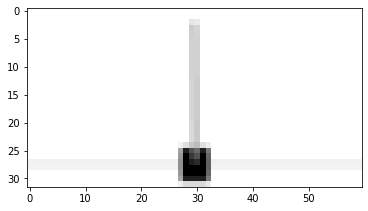

In [2]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize((32,60)),
                    T.Grayscale(),
                    T.ToTensor()])

def get_screen():
    # 800x1200x3
    screen = env.render(mode='rgb_array')
    # Cart is in the lower half, so strip off the top and bottom of the screen
    screen_height, screen_width, _ = screen.shape # HWC
    screen = screen[int(screen_height*0.4):int(screen_height * 0.8), :]
    # Resize
    img = resize(screen) #CHW: 1*32*60
    return img.unsqueeze(0)

env.reset()
img = get_screen().squeeze(0).squeeze(0)
print(img.size())
plt.figure()
plt.imshow(img.numpy(), cmap ='gray')
plt.show()


In [10]:
def get_img_state(img_state):
    if img_state is None:
        pre_img = get_screen()
        curr_img = pre_img
        return torch.cat((pre_img, curr_img), 1) #torch.cat() vs torch.stack()
    else:
        pre_img = img_state[0:, 1:, :]
        curr_img = get_screen()
        return torch.cat((pre_img, curr_img), 1)

## 2. Replay Memory

In [11]:
Experience = namedtuple('Experience', ('state', 'action', 'reward', 'next_state', 'terminal'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.append(Experience(*args)) ## append a new experience

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self): ## len(experience)
        return len(self.memory)


experience_pool = ReplayMemory(50000) #initialize memory pool

## 3. Q-Network

In [12]:
policy_net = nn.Sequential(
        nn.Conv2d(2, 6, 5),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(6, 16, 5),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 12, 120), # ???
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 2))

target_net = nn.Sequential(
        nn.Conv2d(2, 6, 5),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(6, 16, 5),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 12, 120), # ???
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 2))

target_net.load_state_dict(policy_net.state_dict()) ## copy policy to target

<All keys matched successfully>

## 4. Hyperparameters


In [13]:
EPOCHS = 1001
EPOCH_STEPS = 200
BATCH_SIZE = 32 #batch-train
WARM_UP_SIZE = BATCH_SIZE
GAMMA = 0.99 #reward-discount: 0.99 is better than 0.90 !!!!!!
EPS_GREEDY = 0.1 #epsilon-greedy
EPS_DEC = 1e-6 #adaptive epsilon greedy
TARGET_UPDATE = 200 #policy to target

#optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
optimizer = optim.SGD(policy_net.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

## 5. Optimize



In [14]:
def update_policy_net():
    experiences = experience_pool.sample(BATCH_SIZE)
    experiences_batch = Experience(*zip(*experiences)) #experiences of batches

    state_batch = torch.stack(experiences_batch.state)
    action_batch = torch.stack(experiences_batch.action)
    reward_batch = torch.stack(experiences_batch.reward)
    next_state_batch = torch.stack(experiences_batch.next_state)
    terminal_batch = torch.stack(experiences_batch.terminal)

    output_policy = policy_net(state_batch)
    policy_q_value = torch.squeeze(torch.gather(output_policy, 1, action_batch))

    with torch.no_grad():
        output_target_next = target_net(next_state_batch)
        target_next_q_value = torch.max(output_target_next, dim=1).values

    target_q_value = reward_batch + GAMMA * target_next_q_value * (1 - terminal_batch)

    # mean square loss
    loss = loss_fn(policy_q_value, target_q_value)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## 6. Exploration

In [15]:
def greedy_action(state): # state is tensor
    with torch.no_grad():
        action = torch.argmax(policy_net(state)).item()
    return action #return integer

def sample_action(state):
    global EPS_GREEDY
    current_eps = np.maximum(0.01, EPS_GREEDY)
    EPS_GREEDY -= EPS_DEC
    if np.random.rand() < (1.0 - current_eps): #choose a by policy-NN
        action = greedy_action(state) #greedy
    else:
        action = np.random.randint(n_action) #random action

    return torch.tensor([action], dtype=torch.int64) #return tensor

def explore_one_step(state, pool):
    action = sample_action(state) # a
    _, r, done, _ = env.step(action.item())

    reward = torch.tensor(r, dtype=torch.float) # r
    
    next_state = get_img_state(state) # s'
    
    terminal = torch.tensor(int(done) * 1.0, dtype=torch.float) # t

    # Store the transition in experience pool
    pool.push(state, action, reward, next_state, terminal) #(s,a,r,s',t), tensors

    return done, next_state, r

## 7. Train Loop

In [16]:
def evaluate():
    env.reset()
    state = get_img_state(None)
    while True:
        action = torch.argmax(policy_net(state)).item()
        _, _, done, _ = env.step(action)
        
        state = get_img_state(state) # s'

        if done:
            break # one episode

def train_loop():
    update_policy_steps = 0
    for epoch in range(EPOCHS):
        explore_steps = 0
        reward = 0
        # Initialize the environment and state
        env.reset()
        state = get_img_state(None)
        while explore_steps < EPOCH_STEPS:
            explore_steps += 1
            # generate experience
            done, next_state, r = explore_one_step(state, experience_pool)
            state = next_state
            reward += r
            # Perform one step of the optimization
            if len(experience_pool) > WARM_UP_SIZE:
                update_policy_net()
                update_policy_steps += 1
                # Update the target network, copying all weights and biases from policy network
                if update_policy_steps % TARGET_UPDATE == 0:
                    target_net.load_state_dict(policy_net.state_dict())
            if done:
                break # one episode

        if epoch % 50 == 0:
            print("epoch: ", epoch, "reward: ", reward)
            evaluate()

In [17]:
train_loop()

NameError: name 'n_action' is not defined

## 8. Load Saved Model

In [ ]:
#torch.save(policy_net.state_dict(), 'policy.pt')
policy_net.load_state_dict(torch.load('policy.pt'))

evaluate()